# Sirene Sound Classification



## Step 1:  Data Exploration and Visualisation

### Basic Libraries 

In [1]:
import os
import pandas as pd
from glob import glob
import numpy as np

### Importing Keras for Deep Learning and Librosa 

In [2]:
from keras import layers
from keras import models
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
import keras.backend as K
import librosa
import librosa.display
import pylab
import matplotlib.pyplot as plt
from matplotlib import figure
import gc
from path import Path

Using TensorFlow backend.


### Waveplot of Sirene

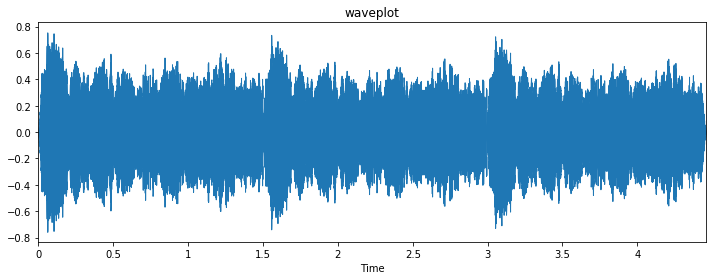

In [3]:
y,sr=librosa.load("sirene.wav")
plt.figure(figsize=(10,4))
librosa.display.waveplot(np.array(y),sr=22050)
plt.title('waveplot')
plt.tight_layout()

### MFCC of Sirene

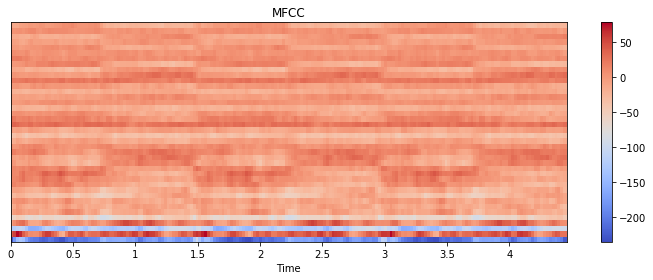

In [4]:
y,sr=librosa.load("sirene.wav")
mfccs = librosa.feature.mfcc(y, sr, n_mfcc=40)
plt.figure(figsize=(10,4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()

### Melspectrogram of Sirine

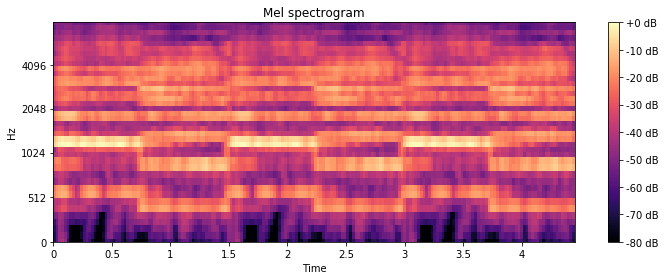

In [5]:
melspectrogram =librosa.feature.melspectrogram(y=y, sr=sr, n_mels=40,fmax=8000)
plt.figure(figsize=(10,4))
librosa.display.specshow(librosa.power_to_db(melspectrogram,ref=np.max),y_axis='mel', fmax=8000,x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

### Chromagram of Sirne

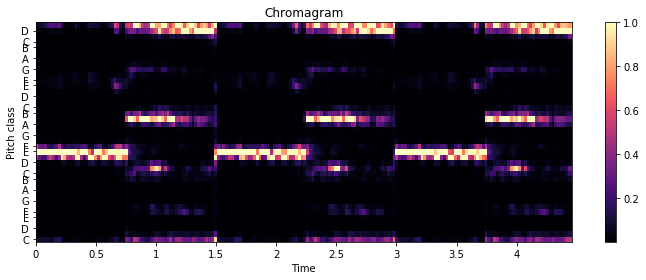

In [6]:
chroma_stft=librosa.feature.chroma_stft(y=y, sr=sr,n_chroma=40)
plt.figure(figsize=(10,4))
librosa.display.specshow(chroma_stft, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('Chromagram')
plt.tight_layout()

## Step 2: Data Preprocessing and Data Splitting

In [7]:
def create_spectrogram(filename,name):
    plt.interactive(False)
    clip, sample_rate = librosa.load(filename, sr=None)
    fig = plt.figure(figsize=[0.72,0.72])
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    S = librosa.feature.melspectrogram(y=clip, sr=sample_rate)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
    filename  = 'train.jpg/' + name + '.jpg'
    plt.savefig(filename, dpi=400, bbox_inches='tight',pad_inches=0)
    plt.close()    
    fig.clf()
    plt.close(fig)
    plt.close('all')
    del filename,name,clip,sample_rate,fig,ax,S

In [8]:
def create_spectrogram_test(filename,name):
    plt.interactive(False)
    clip, sample_rate = librosa.load(filename, sr=None)
    fig = plt.figure(figsize=[0.72,0.72])
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    S = librosa.feature.melspectrogram(y=clip, sr=sample_rate)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
    filename  = Path('test.jpg/' + name + '.jpg')
    fig.savefig(filename, dpi=400, bbox_inches='tight',pad_inches=0)
    plt.close()    
    fig.clf()
    plt.close(fig)
    plt.close('all')
    del filename,name,clip,sample_rate,fig,ax,S

### Splitting the Conversion in different cells and collecting the garbage to avoid Ram Overflow

In [9]:
Data_dir=np.array(glob("Train/*"))
print(Data_dir)

['Train/1332.wav' 'Train/8520.wav' 'Train/2262.wav' ... 'Train/8073.wav'
 'Train/6204.wav' 'Train/78.wav']


In [ ]:
i=0
for file in Data_dir[i:i+2000]:
    #Define the filename as is, "name" refers to the JPG, and is split off into the number itself. 
    filename,name = file,file.split('/')[-1].split('.')[0]
    create_spectrogram(filename,name)

In [ ]:
i=2000
for file in Data_dir[i:i+2000]:
    filename,name = file,file.split('/')[-1].split('.')[0]
    create_spectrogram(filename,name)

In [ ]:
i=4000
for file in Data_dir[i:]:
    filename,name = file,file.split('/')[-1].split('.')[0]
    create_spectrogram(filename,name)

### Keras preprocessing image

In [10]:
from keras_preprocessing.image import ImageDataGenerator

def append_ext(fn):
    return fn +".jpg"

traindf=pd.read_csv('CSV_Dateien/train.csv',dtype=str)
testdf=pd.read_csv('CSV_Dateien/test.csv',dtype=str)
traindf["ID"]=traindf["ID"].apply(append_ext)
testdf["ID"]=testdf["ID"].apply(append_ext)

datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25)


train_generator=datagen.flow_from_dataframe(
    dataframe=traindf,
    directory="train.jpg/",
    x_col="ID",
    y_col="Class",
    subset="training",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(64,64))

valid_generator=datagen.flow_from_dataframe(
    dataframe=traindf,
    directory="train.jpg/",
    x_col="ID",
    y_col="Class",
    subset="validation",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(64,64))

Found 4077 validated image filenames belonging to 10 classes.
Found 1358 validated image filenames belonging to 10 classes.


## Step 3: Model Training and Evaluation

### Preparing the Model 

In [11]:
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from keras.utils import np_utils

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(64,64,3)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
model.compile(optimizers.rmsprop(lr=0.0005, decay=1e-6),loss="categorical_crossentropy",metrics=["accuracy"])
model.summary()
score = model.evaluate(valid_generator, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 62, 62, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 31, 31, 64)       

### Training

In [12]:
from keras.utils import np_utils


STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
#STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=150
)

model.evaluate_generator(generator=valid_generator, steps=STEP_SIZE_VALID
)
score = model.evaluate_generator(generator=valid_generator, steps=STEP_SIZE_VALID
)


print("Training Accuracy: ", score[1])
model.save('my_model')


Epoch 1/150
127/127 [==============================] - 69s 542ms/step - loss: 2.1282 - accuracy: 0.2012 - val_loss: 2.0093 - val_accuracy: 0.2708
Epoch 2/150
127/127 [==============================] - 66s 521ms/step - loss: 1.8763 - accuracy: 0.3182 - val_loss: 1.6140 - val_accuracy: 0.4540
Epoch 3/150
127/127 [==============================] - 67s 524ms/step - loss: 1.4933 - accuracy: 0.4808 - val_loss: 1.3097 - val_accuracy: 0.5686
Epoch 4/150
127/127 [==============================] - 66s 523ms/step - loss: 1.2082 - accuracy: 0.5926 - val_loss: 1.0647 - val_accuracy: 0.6071
Epoch 5/150
127/127 [==============================] - 67s 524ms/step - loss: 1.0559 - accuracy: 0.6425 - val_loss: 0.8489 - val_accuracy: 0.6938
Epoch 6/150
127/127 [==============================] - 67s 528ms/step - loss: 0.9002 - accuracy: 0.7019 - val_loss: 1.3279 - val_accuracy: 0.6546
Epoch 7/150
127/127 [==============================] - 67s 525ms/step - loss: 0.7826 - accuracy: 0.7407 - val_loss: 0.6643 -

Epoch 57/150
127/127 [==============================] - 67s 525ms/step - loss: 0.0822 - accuracy: 0.9771 - val_loss: 0.1013 - val_accuracy: 0.9427
Epoch 58/150
127/127 [==============================] - 66s 516ms/step - loss: 0.0815 - accuracy: 0.9784 - val_loss: 0.2859 - val_accuracy: 0.9020
Epoch 59/150
127/127 [==============================] - 66s 518ms/step - loss: 0.0868 - accuracy: 0.9765 - val_loss: 0.9649 - val_accuracy: 0.9397
Epoch 60/150
127/127 [==============================] - 66s 520ms/step - loss: 0.0951 - accuracy: 0.9739 - val_loss: 0.0961 - val_accuracy: 0.9389
Epoch 61/150
127/127 [==============================] - 66s 516ms/step - loss: 0.0844 - accuracy: 0.9747 - val_loss: 0.9403 - val_accuracy: 0.9035
Epoch 62/150
127/127 [==============================] - 66s 517ms/step - loss: 0.0953 - accuracy: 0.9731 - val_loss: 0.0152 - val_accuracy: 0.9389
Epoch 63/150
127/127 [==============================] - 66s 520ms/step - loss: 0.0598 - accuracy: 0.9828 - val_loss: 0

127/127 [==============================] - 66s 523ms/step - loss: 0.0900 - accuracy: 0.9805 - val_loss: 0.8670 - val_accuracy: 0.9261
Epoch 113/150
127/127 [==============================] - 66s 522ms/step - loss: 0.1184 - accuracy: 0.9758 - val_loss: 0.0510 - val_accuracy: 0.9336
Epoch 114/150
127/127 [==============================] - 66s 524ms/step - loss: 0.1330 - accuracy: 0.9718 - val_loss: 0.1967 - val_accuracy: 0.9155
Epoch 115/150
127/127 [==============================] - 66s 524ms/step - loss: 0.1098 - accuracy: 0.9765 - val_loss: 1.5584 - val_accuracy: 0.9449
Epoch 116/150
127/127 [==============================] - 67s 528ms/step - loss: 0.0989 - accuracy: 0.9768 - val_loss: 0.3805 - val_accuracy: 0.9306
Epoch 117/150
127/127 [==============================] - 66s 523ms/step - loss: 0.1243 - accuracy: 0.9750 - val_loss: 9.6524e-04 - val_accuracy: 0.9321
Epoch 118/150
127/127 [==============================] - 66s 521ms/step - loss: 0.1216 - accuracy: 0.9734 - val_loss: 0.99

In [14]:
from keras.models import load_model
model = load_model('my_model')

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
score = model.evaluate_generator(generator=train_generator, steps=STEP_SIZE_TRAIN
)
print("Training Accuracy: ", 100*score[1],"%")
print("Training Loss: ", 100*score[0],"%")
score = model.evaluate_generator(generator=valid_generator, steps=STEP_SIZE_VALID
)
print("Valid Accuracy: ", 100*score[1],"%")
print("Valid Loss: ", 100*score[0],"%")


Training Accuracy:  99.97539520263672 %
Training Loss:  0.052781018894165754 %
Valid Accuracy:  93.15476417541504 %
Valid Loss:  126.22909545898438 %


### Accuracy and loss Training/Validation Diagram

<Figure size 1584x720 with 0 Axes>

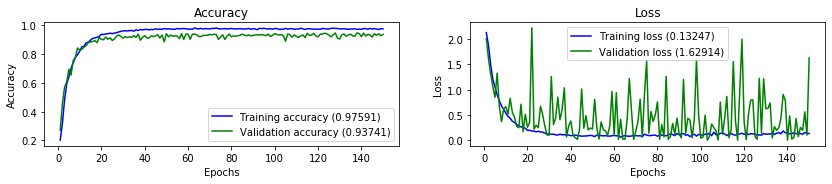

In [15]:
loss_list = [s for s in history.history.keys() if
    'loss' in s and 'val' not in s]
val_loss_list = [s for s in history.history.keys()
    if 'loss' in s and 'val' in s]
acc_list = [s for s in history.history.keys() if
    'acc' in s and 'val' not in s]
val_acc_list = [s for s in history.history.keys()
    if 'acc' in s and 'val' in s]
if len(loss_list) == 0:
    print('Loss is missing in history')
    plt.figure(figsize=(22,10))
## As loss always exists
epochs = range(1,len(history.history[loss_list[0]]) + 1)
## Accuracy
plt.figure(221, figsize=(22,10))
## Accuracy
plt.figure(2,figsize=(14,5))
plt.subplot(221, title='Accuracy')
for l in acc_list:
    plt.plot(epochs, history.history[l], 'b',
label='Training accuracy (' + str(
format(history.history[l][-1],'.5f'))+
 ')')
for l in val_acc_list:
    plt.plot(epochs, history.history[l], 'g',
 label='Validation accuracy (' + str(
format(history.history[l][-1],'.5f'))+
')')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
## Loss
plt.subplot(222, title='Loss')
for l in loss_list:
    plt.plot(epochs, history.history[l], 'b',
label='Training loss (' + str(str(
format(history.history[l][-1],'.5f'))+
')'))
for l in val_loss_list:
    plt.plot(epochs, history.history[l], 'g',
label='Validation loss (' + str(str(
format(history.history[l][-1],'.5f'))+
 ')'))
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Step 4: Testing

In [16]:
Test_dir=np.array(glob("testing/*"))
print(Test_dir)

['testing/1509.wav' 'testing/8454.wav' 'testing/7492.wav' ...
 'testing/7627.wav' 'testing/3472.wav' 'testing/2880.wav']


In [ ]:
i=0
for file in Test_dir[i:i+1500]:
    filename,name = file,file.split('/')[-1].split('.')[0]
    create_spectrogram_test(filename,name)

In [ ]:
i=1500
for file in Test_dir[i:]:
    filename,name = file,file.split('/')[-1].split('.')[0]
    create_spectrogram_test(filename,name)
gc.collect()

In [17]:
from keras.models import load_model
model = load_model('my_model')

test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator=test_datagen.flow_from_dataframe(
    dataframe=testdf,
    directory="test.jpg/",
    x_col="ID",
    y_col=None,
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode=None,
    target_size=(64,64))
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

test_generator.reset()
pred=model.predict_generator(test_generator,
steps=STEP_SIZE_TEST,verbose=1)
print("test_generator: ", test_generator)
print("STEP_SIZE_TEST: ", STEP_SIZE_TEST)
print(pred)

Found 3297 validated image filenames.
103/103 [==============================] - 11s 107ms/step
test_generator:  <keras_preprocessing.image.dataframe_iterator.DataFrameIterator object at 0x7fb360542590>
STEP_SIZE_TEST:  103
[[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 1.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [3.8513376e-21 5.7086572e-19 6.9713647e-06 ... 2.7559872e-22
  1.1656118e-12 8.6409782e-11]
 [1.1411565e-37 0.0000000e+00 1.2953108e-23 ... 0.0000000e+00
  1.0080694e-31 3.7951744e-27]
 ...
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [1.2694728e-15 1.5143948e-08 7.3176802e-19 ... 1.0000000e+00
  1.3446605e-32 3.3816368e-17]
 [8.9869658e-09 4.2426419e-03 1.2897020e-05 ... 1.4307088e-07
  5.4293722e-03 9.9025178e-01]]


## Step 5: Making predictions and writing it to CSV

In [20]:
predicted_class_indices=np.argmax(pred,axis=1)

#Fetch labels from train gen for testing
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
#print(predictions[0:10])
for i in range(0,10):
    #print(testdf.head(i+1))
    print(labels[predicted_class_indices[i]])
    print("{:2.4f}".format(max(pred[i])*100)+ " %")
    print("---------")
    
filenames=test_generator.filenames
results=pd.DataFrame({"Predictions":predictions})
results.to_csv("CSV_Dateien/results.csv",index=False)

jackhammer
100.0000 %
---------
dog_bark
99.9993 %
---------
drilling
100.0000 %
---------
dog_bark
100.0000 %
---------
street_music
99.9954 %
---------
jackhammer
100.0000 %
---------
air_conditioner
99.9999 %
---------
children_playing
100.0000 %
---------
dog_bark
100.0000 %
---------
siren
100.0000 %
---------



## Validation: Test with sample data

In [21]:
def create_spectrogram_test_validation(filename,name):
    plt.interactive(False)
    clip, sample_rate = librosa.load(filename, sr=None)
    fig = plt.figure(figsize=[0.72,0.72])
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    S = librosa.feature.melspectrogram(y=clip, sr=sample_rate)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
    filename  = Path('Sirene/' + name + '.jpg')
    fig.savefig(filename, dpi=400, bbox_inches='tight',pad_inches=0)
    plt.close()    
    fig.clf()
    plt.close(fig)
    plt.close('all')
    del filename,name,clip,sample_rate,fig,ax,S

In [22]:
Test_dir=np.array(glob("Sirene/*"))

for file in Test_dir:
    filename,name = file,file.split('/')[-1].split('.')[0]
    create_spectrogram_test_validation(filename,name)

In [25]:
from keras.models import load_model
model = load_model('my_model') 

def append_ext(fn):
    return fn +".jpg"


testdf_valid=pd.read_csv('CSV_Dateien/test_valid.csv',dtype=str)
testdf_valid["ID"]=testdf_valid["ID"].apply(append_ext)
print(testdf_valid)
test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator=test_datagen.flow_from_dataframe(
    dataframe=testdf_valid,
    directory="Sirene/",
    x_col="ID",
    y_col=None,
    batch_size=1,
    seed=42,
    shuffle=False,
    class_mode=None,
    target_size=(64,64))
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size


test_generator.reset()
pred=model.predict_generator(test_generator,
steps=STEP_SIZE_TEST,
verbose=1)
print("test_generator: ", test_generator)
print("STEP_SIZE_TEST: ", STEP_SIZE_TEST)


                  ID
0  sirene_Test_1.jpg
1  sirene_Test_2.jpg
2  sirene_Test_3.jpg
3  sirene_Test_4.jpg
Found 4 validated image filenames.
4/4 [==============================] - 0s 20ms/step
test_generator:  <keras_preprocessing.image.dataframe_iterator.DataFrameIterator object at 0x7fb35436ee10>
STEP_SIZE_TEST:  4


In [27]:


predicted_class_indices=np.argmax(pred,axis=0)

#Fetch labels from train gen for testing
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
print(labels)
for i in range(0,4):
    #print(labels[predicted_class_indices[i]])
    index= pred[i].argmax()
    print(labels[index])
    print("{:2.4f}".format(max(pred[i])*100)+ " %")

{0: 'air_conditioner', 1: 'car_horn', 2: 'children_playing', 3: 'dog_bark', 4: 'drilling', 5: 'engine_idling', 6: 'gun_shot', 7: 'jackhammer', 8: 'siren', 9: 'street_music'}
siren
99.9996 %
drilling
100.0000 %
siren
100.0000 %
children_playing
99.9991 %
